## Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import convolve
from skimage.feature import peak_local_max

import sys
sys.path.insert(1, '..')
from functions import *

PATH = 'data/'

## 2.2.1  Computing Gaussian and its second order derivative

In this exercise you will implement scale-space blob detection to detect and measure glass fibres from images of a glass fibre composite. An image example in Figure 2.1 shows a polished surface of a glass fibre composite sample, where individual fibres can be seen. Since these fibres are relatively circular we will model them as circles. This means that we must find their position (center coordinate) and diameter, and for this we will use the scale-space blob detection. After having computed the fibres parameters, we will carry a statistical analysis of the results.

1. **Derive (analytically) the second order derivative of the Gaussian**

2. **Implement the function**

    Implement a function that takes the variance $t$ as input and outputs a filter kernel of $g$ and $d^2g/dx^2$. You should use a filter kernel with a size of at least $\pm3 \sqrt{t}$. Why? 
    
    **Hint:** Set a variable $r = ⌈3\sqrt{t}⌉$, make an array with the integer values $[−r, . . . , r]$ and compute the Gaussian on these values.

3. Try the filter kernel on the synthetic test image ```test_blob_uniform.png``` and inspect the result.

The Gaussian equation is given as:

\begin{equation}
 g(x;t) = \frac{1}{\sqrt{2t\pi}} \exp \left (-\frac{x^2}{2t} \right )
\end{equation}

Taking the first derivative (Use the product rule for the exp term)

\begin{align}
 \frac{\partial}{\partial x} g(x;t) &= \frac{1}{\sqrt{2t\pi}} \frac{\partial}{\partial x} \exp \left (-\frac{x^2}{2t} \right ) \\
 &= \frac{1}{\sqrt{2t\pi}} \exp \left (-\frac{x^2}{2t} \right ) \cdot \left (-\frac{x}{t} \right ) \\
 &= - \frac{x}{t} g(x;t)
\end{align}

Taking the second derivate 

\begin{align}
 \frac{\partial^2}{\partial x^2} g(x;t) &= -  \frac{\partial}{\partial x} \left ( \frac{x}{t} g(x;t) \right )\\
 &= - \left ( \frac{\partial}{\partial x}  \frac{x}{t}  g(x;t) + \frac{x}{t} \frac{\partial}{\partial x} g(x;t) \right )   \\
 &= - \left ( \frac{1}{t}  g(x;t) - \frac{x^2}{t^2} g(x;t) \right )   \\
 &= - \left ( \frac{1}{t} - \frac{x^2}{t^2} \right )  g(x;t)   \\
 &= \left (\frac{x^2}{t^2} -  \frac{1}{t} \right )  g(x;t)   \\
\end{align}

In [2]:
def gaussian_2grad(n, t):
    """
    Computes the second derivative of a Gaussian function.

    Parameters:
        n (int): The factor to determine the radius of the kernel.
        t (float): The variance (sigma squared) of the Gaussian function.

    Returns:
        numpy.ndarray: The second derivative of the Gaussian function evaluated at each point in x.
    """

    RADIUS = np.ceil(n*np.sqrt(t))
    x = np.arange(-RADIUS, RADIUS + 1)
    assert RADIUS > 3*np.sqrt(t), 'RADIUS must be larger than 3*sqrt(t)'

    kernel = (x**2/t**2 - 1/t) * gaussian_1D_kernel(n, t)
    return kernel/np.sum(np.abs(kernel))

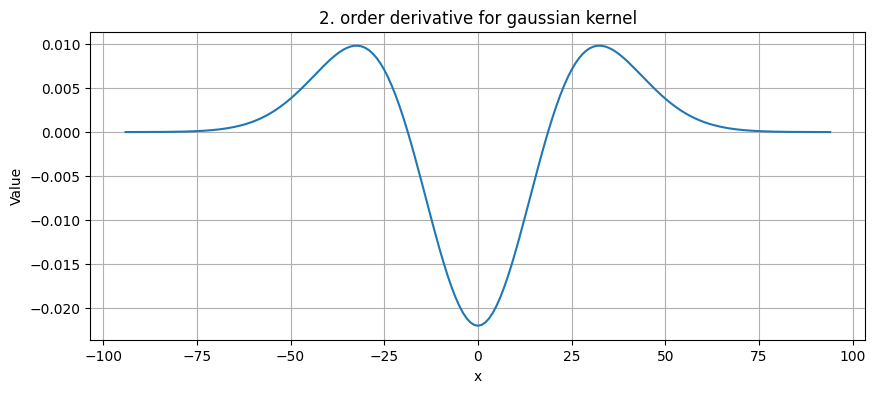

In [3]:
t = 350
n = 5
kernel_2grad = gaussian_2grad(n, t)

# Get the range for the plot
RADIUS = np.ceil(n*np.sqrt(t))
x = np.arange(-RADIUS, RADIUS + 1)

# Plot the kernels
plt.figure(figsize=(10, 4))

# Plot normalized Gaussian kernel
plt.plot(x, kernel_2grad)
plt.title(f"2. order derivative for gaussian kernel")
plt.xlabel("x")
plt.ylabel("Value")
plt.grid()


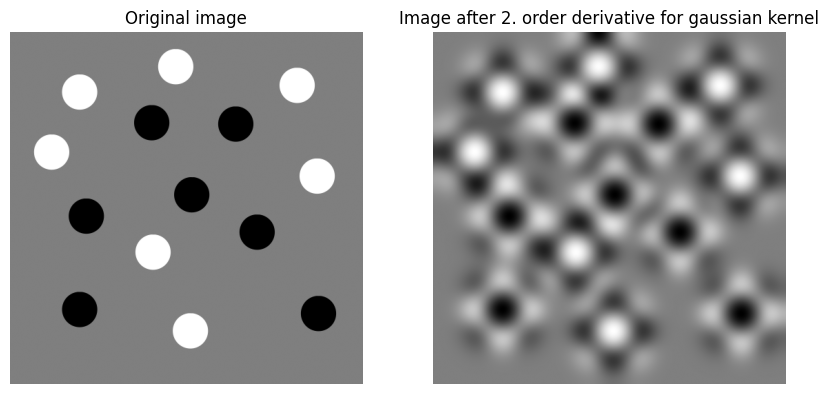

In [4]:
image = get_gray_image(PATH + 'test_blob_uniform.png')
image_blurred = convolve_2d(image, kernel_2grad)

fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(image, cmap='gray')
ax[0].set_title("Original image")
ax[0].axis('off')
ax[1].imshow(image_blurred, cmap='gray')
ax[1].set_title("Image after 2. order derivative for gaussian kernel")
ax[1].axis('off')
plt.show()

## 2.1.2 Detecting blobs at one scale

Here you will implement a function to detect blobs at a single scale. Blobs can be found as spatial maxima (dark blobs) or minima (bright blobs) of the Laplacian

\begin{equation}
    \nabla L^2 = L_{xx} + L_{yy}
\end{equation}

1. **Compute the Laplacian**

    Compute the Laplacian of the scale-space containing only one scale for the synthetic test image test_blob_uniform.png. When using separable 1D kernels to compute Lxx and Lyy, remember to convolve with second order Gaussian derivative in the one direction, and with the Gaussian smoothing kernel in the other direction. This is because Lxx and Lyy correspond to derivatives of the image smoothed with 2D kernel.


2. **Detect of maxima and minima in the Laplacian**

    You can make your own function or use peak_local_max from skimage.feature Detect blobs as maxima or minima that have an absolute value of the Laplacian larger than some threshold.

3. **Plot the center coordinates and circles outlining the detected blobs**

    The radius of the circles should be $\sqrt(2t)$


4. **Try varying t such that the blobs in ``test_blob_uniform.png`` are exactly outlined**

In [15]:
def Laplacian(image, t, normalize=True, n=5):
    """
    Applies the Laplacian of Gaussian (LoG) operator to an image.

    Parameters:
        image (ndarray): The input image on which the Laplacian of Gaussian is to be applied.
        t (float): The standard deviation of the Gaussian kernel.
        n (int, optional): The size of the kernel. Default is 5.

    Returns:
        ndarray: The result of applying the Laplacian of Gaussian to the image.
    """
    kernel_2grad = gaussian_2grad(n, t)
    kernel_gaussian = gaussian_1D_kernel(n, t)

    L_xx = convolve(image, kernel_2grad.reshape(1,-1))
    L_xx = convolve(L_xx, kernel_gaussian.reshape(-1,1))

    L_yy = convolve(image, kernel_2grad.reshape(-1,1))
    L_yy = convolve(L_yy, kernel_gaussian.reshape(1,-1))

    L = L_xx + L_yy
    if normalize:
        return t*L
    
    else:
        return L

7


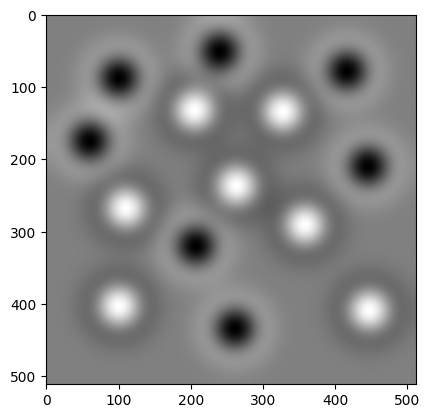

In [6]:
t = 350
L = Laplacian(image, t, False)

# Find the maximum
threds_hold = 0.2
local_max = peak_local_max(L, threshold_abs=threds_hold)
local_min = peak_local_max(-L, threshold_abs=threds_hold)
print(len(local_max))

# Plot the image and the Laplacian
plt.imshow(L, cmap='gray')

In [7]:
def plot_image_with_circles(image, local_max=None, local_min=None, t=None, fig_size=(7,7), circles=True, linewidth=1, ax=None):
    """
    Plots an image with detected blobs highlighted by circles.
    Local maxima are plotted in red and local minima in blue.

    Parameters:
        image (ndarray): The input image to be displayed.
        local_max (ndarray or list, optional): Coordinates of the local maxima.
        local_min (ndarray or list, optional): Coordinates of the local minima.
        t (float or list): The variance(s) used for the detected blobs.
        fig_size (tuple, optional): The size of the figure to be created. Default is (7, 7).
        circles (bool, optional): Whether to draw circles around blobs. Default is True.
        linewidth (int, optional): Width of the circles. Default is 1.
        ax (matplotlib.axes.Axes, optional): The axis on which to plot. Default is None.

    Returns:
        None
    """
    # Check if ax is provided, otherwise create a new figure and axis
    if ax is None:
        fig, ax = plt.subplots(figsize=fig_size)
    
    ax.imshow(image, cmap='gray', vmin=0, vmax=1)
    ax.axis('off')

    # Plot local maxima (in red)
    if local_max is not None:
        if isinstance(local_max, list):
            for (points, scale) in zip(local_max, t):
                for maxima in points:
                    y, x = maxima
                    if circles:
                        c = plt.Circle((x, y), np.sqrt(2*scale), color='r', linewidth=linewidth, fill=False)
                        ax.add_patch(c)
                    else:
                        ax.plot(x, y, 'ro', markersize=linewidth)
        else:
            for maxima in local_max:
                y, x = maxima
                if circles:
                    c = plt.Circle((x, y), np.sqrt(2*t), color='r', linewidth=linewidth, fill=False)
                    ax.add_patch(c)
                else:
                    ax.plot(x, y, 'ro', markersize=linewidth)

    # Plot local minima (in blue)
    if local_min is not None:
        if isinstance(local_min, list):
            for (points, scale) in zip(local_min, t):
                for minima in points:
                    y, x = minima
                    if circles:
                        c = plt.Circle((x, y), np.sqrt(2*scale), color='b', linewidth=linewidth, fill=False)
                        ax.add_patch(c)
                    else:
                        ax.plot(x, y, 'bo', markersize=linewidth)
        else:
            for minima in local_min:
                y, x = minima
                if circles:
                    c = plt.Circle((x, y), np.sqrt(2*t), color='b', linewidth=linewidth, fill=False)
                    ax.add_patch(c)
                else:
                    ax.plot(x, y, 'bo', markersize=linewidth)

    # Title adjustment
    title = f"Detected blobs with variance: {t}\n"
    if local_max is not None and local_min is None:
        title += " (Maxima in Red)"
    elif local_min is not None and local_max is None:
        title += " (Minima in Blue)"
    elif local_max is not None and local_min is not None:
        title += " (Maxima in Red, Minima in Blue)"
    
    
    
    ax.set_title(title)

    # Only show the plot if ax is None (i.e., a new figure was created)
    if ax is None:
        plt.show()


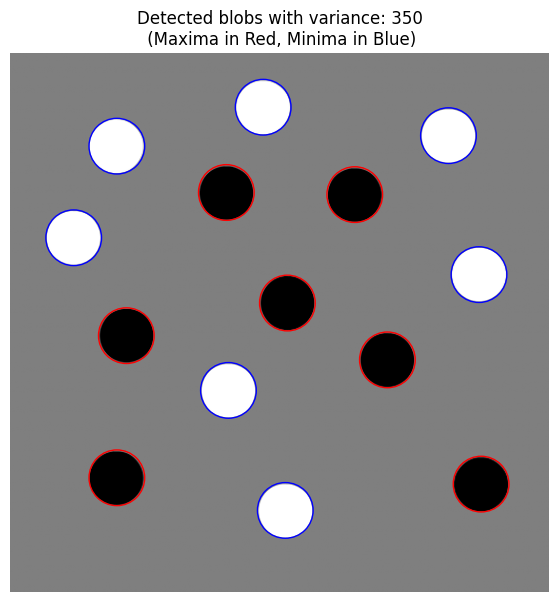

In [8]:
plot_image_with_circles(image, local_max=local_max, local_min=local_min, t=t)

## 2.1.3 Detecting blobs on multiple scales

Now you should extend the blob detection at a single scale to multiple scales. To find blobs at multiple scales, we must use the scale-space representation. This can conveniently be done by representing the Laplacian of the scale-space $\nabla^2L$ as a 3D array (volumetric image).

1. **decide on a set of scales at which the Laplacian must be computed**

    A good idea is to make it at equal steps in t. Remember that the radius of the blobs is $\sqrt(2t)$, so you can visually estimate the size of the structures that you want to detect and decide a good range of scales.

2. **Compute the scale normalized scale-space Laplacian $t\nabla^2L$**

    Do this for the test image ``test_blob_uniform.png``. It is very important that you remember to use scale normalization, i.e. that you multiply the Laplacian $\nabla^2L$ by $t$. Otherwise, you will not detect the correct scales. See the figure below for a sketch of an efficient implementation.

<p align="center">
  <img src="Figures/Sketch of scale space representation.png" width="500">
</p>

3. **Find coordinates and scales of maxima and minima in this scale-space and plot the detected blobs on top of the image**

    What are the detected scales and what is the diameter of the blobs? Remember that a pixel value needs to be larger (or smaller) then neighbors in both spatial dimensions and in the scale dimension. 
    
    **Hint**: To ensure that extrema is correctly detected in the first and the last scale, you can pad the scale-space representation with zeros.

4. **Detect blobs in the test image test_blob_varying.png**

5. **Verify that you detected the blobs at the correct scale**

    Do this by showing an image with the detected blobs plotted on top as circles with a diameter of $\sqrt(2t)$.

In [9]:
t = np.arange(300, 600 + 1 , 100)
print(f' The scale for the variance of the Gaussian kernel is: {t}')

 The scale for the variance of the Gaussian kernel is: [300 400 500 600]


In [10]:
# Pad the array with 0.5 since this is our background value
padded_image = np.pad(image, pad_width=1, mode='constant', constant_values=0.5)

L_norm = []
local_peaks = []
local_mins = []

for i in range(len(t)):
    L = Laplacian(padded_image, t[i], normalize=True)
    L_norm.append(L)
    local_peaks.append(peak_local_max(L, threshold_abs=0.4, min_distance=15, threshold_rel=0.4))
    local_mins.append(peak_local_max(-L, threshold_abs=0.4, min_distance=15, threshold_rel=0.4))

#print(local_peaks)
#print(local_mins)

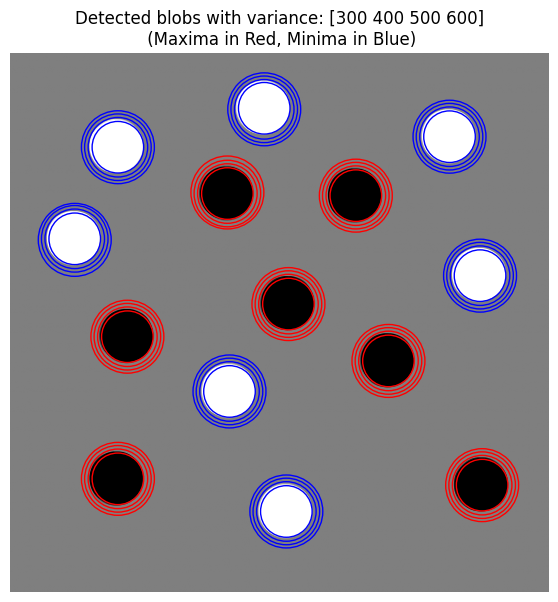

In [11]:
plot_image_with_circles(image, local_max=local_peaks, local_min=local_mins, t=t)

In [12]:
blob_image = get_gray_image(PATH + 'test_blob_varying.png')
padded_blob_image = np.pad(blob_image, pad_width=1, mode='constant', constant_values=0.5)

 The scale for the variance of the Gaussian kernel is: [15, 50, 100, 150, 300, 500, 800, 1000]


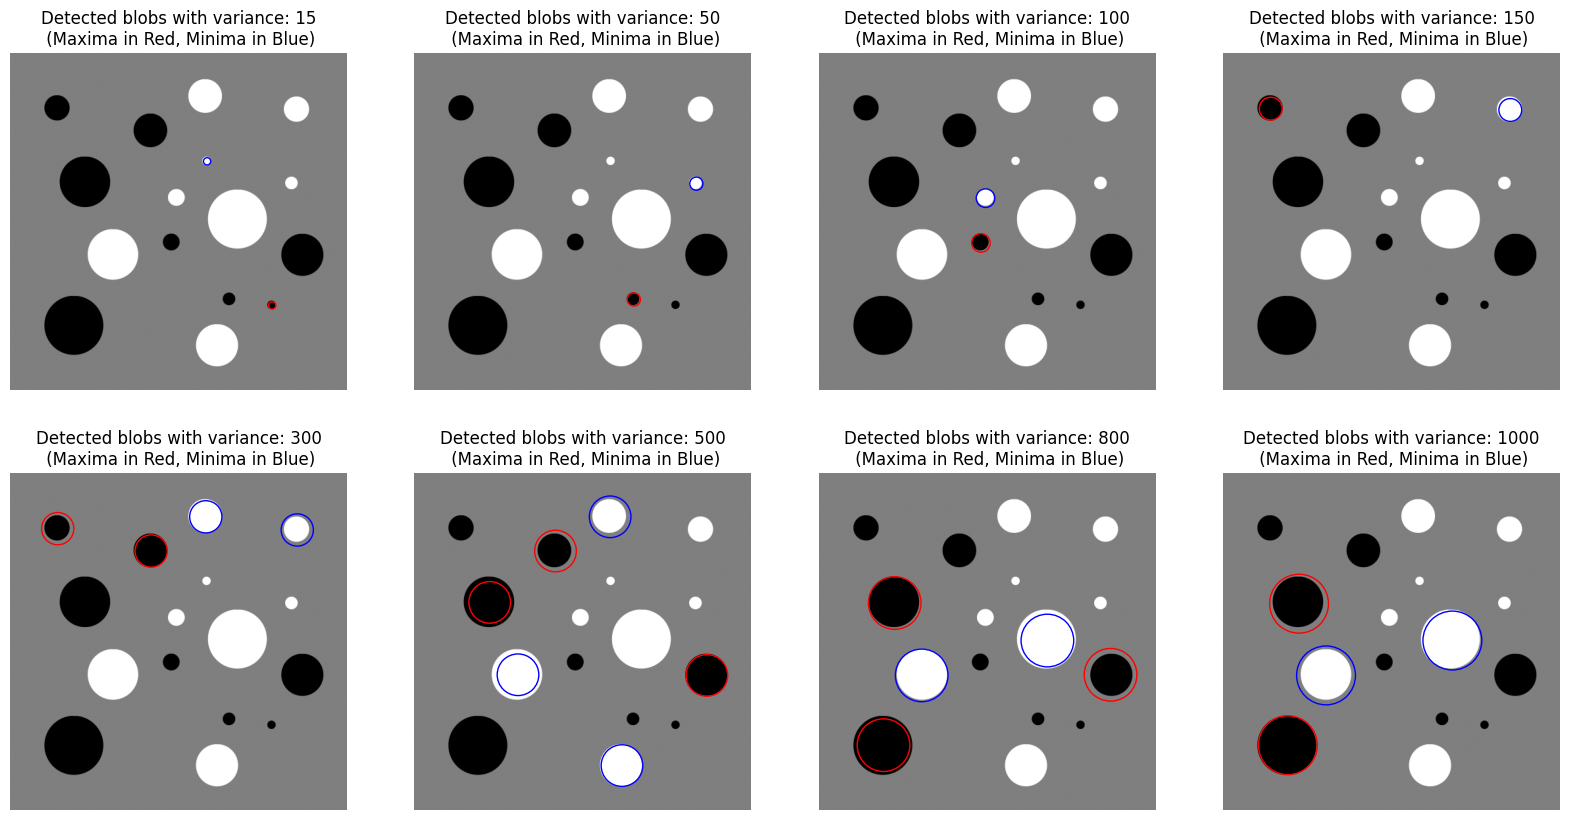

In [13]:
t_list = [15, 50, 100, 150, 300, 500, 800, 1000]
threshold_list = 0.99*np.ones(len(t_list))
print(f' The scale for the variance of the Gaussian kernel is: {t_list}')

L_norm_list = []
local_peaks_list = []
local_mins_list = []

fig, ax = plt.subplots(2, 4, figsize=(20, 10))
ax = ax.ravel()

for i, (t, threshold) in enumerate(zip(t_list, threshold_list)):
    L = Laplacian(padded_blob_image, t)
    L_norm_list.append(L)

    local_peaks = peak_local_max(L,  threshold_abs=0.3, min_distance=15, threshold_rel=0.9) # else use the threshold from the lst
    local_mins = peak_local_max(-L,  threshold_abs=0.3, min_distance=15, threshold_rel=0.9)

    local_peaks_list.append(local_peaks)
    local_mins_list.append(local_mins)

    plot_image_with_circles(blob_image, local_max=local_peaks, local_min=local_mins, t=t, ax=ax[i])

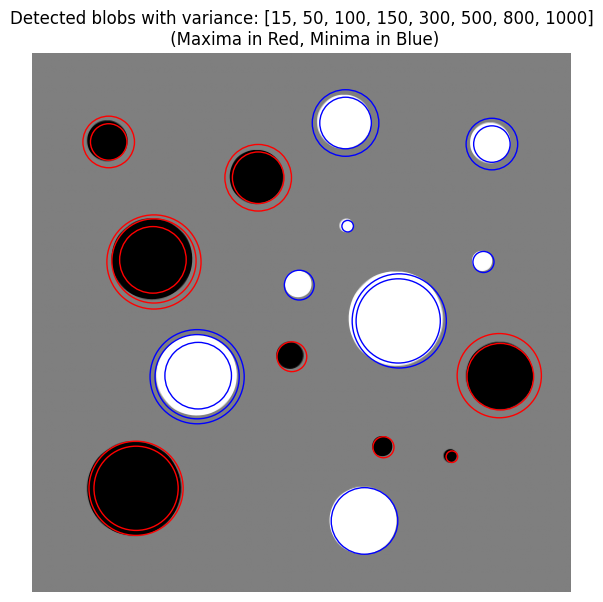

In [14]:
plot_image_with_circles(blob_image, local_max=local_peaks_list, local_min=local_mins_list, t=t_list)

## 2.1.4 Detecting blobs in real data

We will now continue with the real images of fibers. The fibre data is obtained using different scanning methods including scanning electron microscopy ``SEM.png``, optical microscopy ``Optical.png``, synchrotron X-ray CT ``CT_synchrotron.png``, and three resolutions of laboratoryX-ray CT ``CT_lab`` images with high, medium or low resolution. The CT data is a single slice very close to the top of the sample, so we assume the images to be showing the same structures, and this allows us to directly compare the fibers. We will do this comparison in later exercise, but in this we will compute the fiber location and their diameter. In Figure 2.2 you can see a visualization of the fibre data from the high resolution X-ray CT scan. We start by testing the blob-detection on this real data.

1. **Run your blob-detection function from above**

    Use a cut-out example of one of the images. It is important that you tune your parameters to get the best possible results.

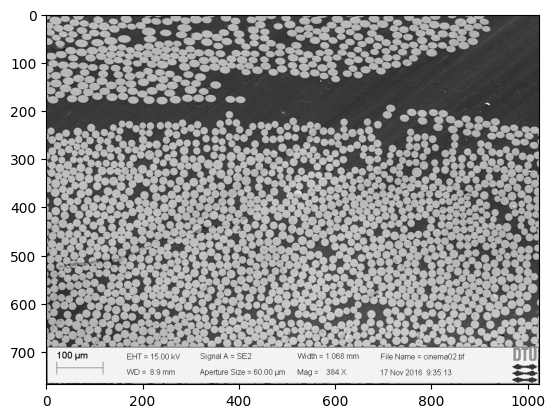

In [15]:
image = get_gray_image(PATH + 'SEM.png')
image_padded = np.pad(image, pad_width=1, mode='constant', constant_values=0.5)
plt.imshow(image, cmap='gray')

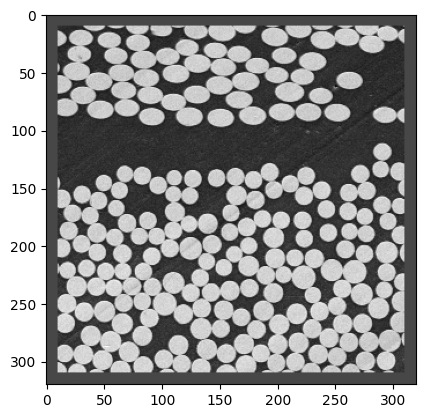

In [16]:
image_subset = image[100:400, 100:400]
image_subset_padded = np.pad(image_subset, pad_width=10, mode='constant', constant_values=.3)
plt.imshow(image_subset_padded, cmap='gray')

 The scale for the variance of the Gaussian kernel is: [33]


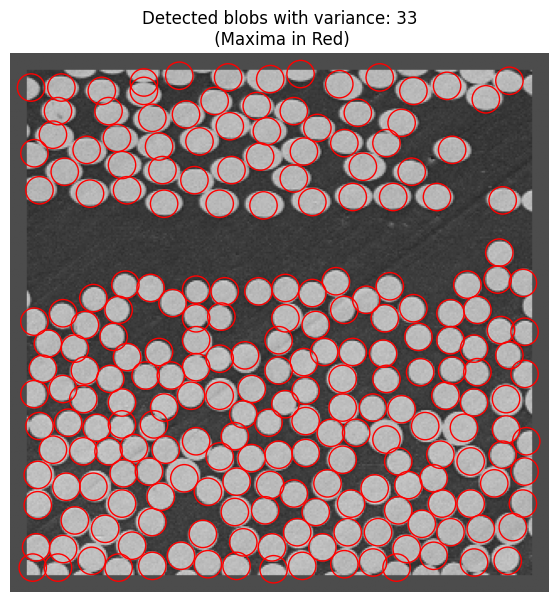

In [17]:
t_list = [33]
threshold_list = 0.1*np.ones(len(t_list))
print(f' The scale for the variance of the Gaussian kernel is: {t_list}')

L_norm_list = []
local_peaks_list = []

for (t, threshold) in zip(t_list, threshold_list):
    L = Laplacian(image_subset_padded, t)  
    L_norm_list.append(L)
    local_peaks = peak_local_max(-L, threshold_rel=threshold) # -1 because I want to find the min
    local_peaks_list.append(local_peaks)
    plot_image_with_circles(image_subset_padded, local_max=local_peaks, t=t)

## 2.1.5 Localizing blobs

It turns out, that it is difficult to detect blobs in the Laplacian scale-space in the fiber image, such that all fibers are found. To overcome this, we will detect the fibers as maxima in a Gaussian smoothed image. Since the fibers are almost the same size, we can use a single scale of the Gaussian to detect the fiber centers.

**1. Smooth an image of fibers with a Gaussian and visualize the result**

**2. Find locations of maxima in this image and plot the positions on top of the original image**

**3. Compute the Laplacian scale-space for the image**

**4. Find the scale of each fibre as the minimum over scales at the fiber locations**

**5. Plot circles according to the found scale on top of the original image**

**6. Detect fibers in all six fiber images. Save the locations and diameters**

In the exercise in Week 3, you will work with feature-based image registration, and you be using the results obtained in this exercise. So, in Week 3 it will be possible to continue working on the parts that you did not finish here.

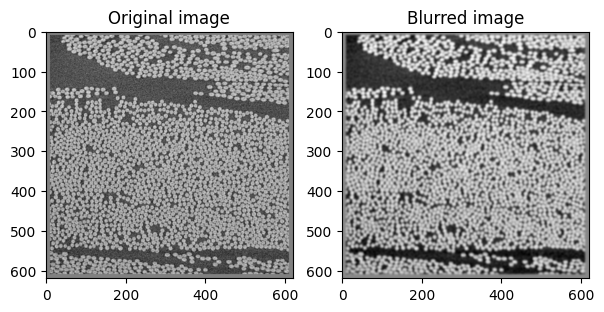

In [3]:
image = get_gray_image(PATH + 'CT_lab_med_res.png')
image = np.pad(image, pad_width=10, mode='constant', constant_values=0.5)

t = 5 #Variance
kernel = gaussian_1D_kernel(5, t)
image_blurred = convolve_2d(image, kernel)


fig, ax = plt.subplots(1, 2, figsize=(7,10))
ax[0].imshow(image, cmap='gray')
ax[0].set_title("Original image")
ax[1].imshow(image_blurred, cmap='gray')
ax[1].set_title("Blurred image")
plt.show()

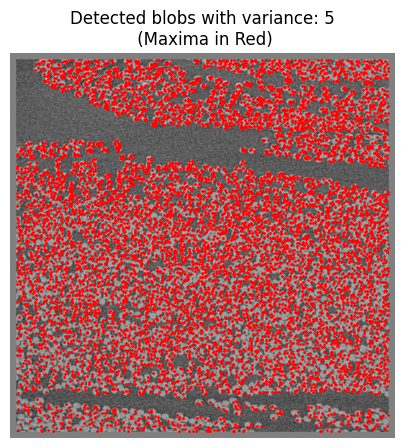

In [4]:
local_maxima = peak_local_max(image, threshold_rel=0.8)
plot_image_with_circles(image, local_max=local_maxima, t=t, circles=False, linewidth=1, fig_size=(5,5))

[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


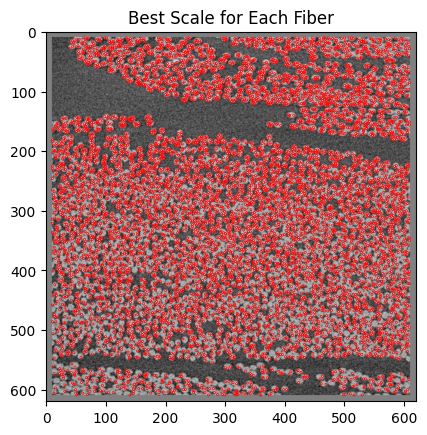

In [5]:
t_list = np.arange(1, 51)
L_stack = np.stack([Laplacian(image, t, normalize=True) for t in t_list], axis=-1) 
print(Laplacian(image, 1, normalize=True))
ys, xs = zip(*local_maxima)
ys = np.array(ys)
xs = np.array(xs)

location_values = L_stack[xs, ys, :] 
min_indices = np.argmin(location_values, axis=1)
best_scales = t_list[min_indices]

location_scale = list(zip(xs, ys, best_scales)) 
plt.imshow(image, cmap='gray')
plt.title('Best Scale for Each Fiber')
for (x, y, scale) in location_scale:
    circle = plt.Circle((x, y), np.sqrt(scale * 3), color='red', fill=False, linewidth=0.5)
    plt.gca().add_patch(circle)

plt.show()

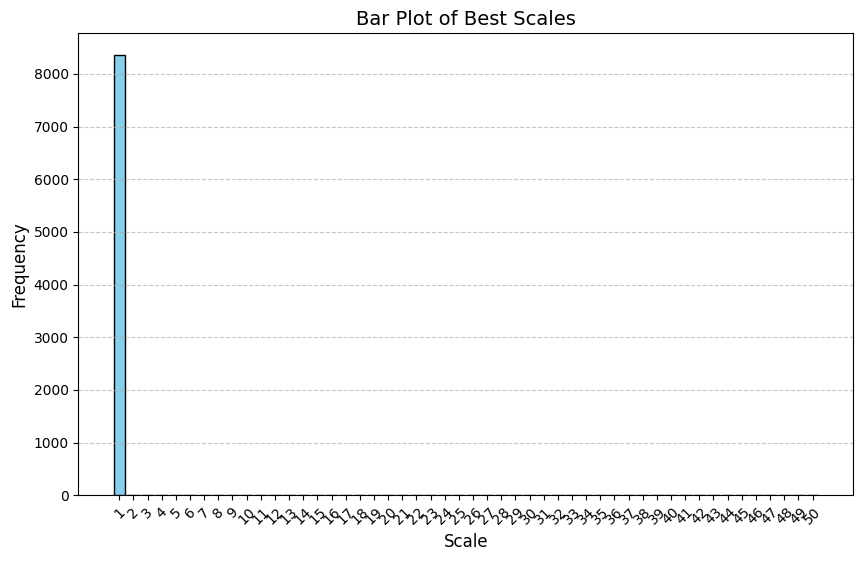

[1 1 1 ... 1 1 1]


In [6]:
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

def plot_scale_barplot(best_scales, t_list):
    """
    Plots a bar plot showing the frequency of each scale in best_scales.
    The x-axis will use the values from t_list as the scale labels.
    
    Parameters:
        best_scales (list): List of best scales (the scale values).
        t_list (numpy.ndarray): List of possible scale values (the t_list array).
    """
    # Count the frequency of each scale in best_scales
    scale_counts = Counter(best_scales)
    
    # Ensure all scales from t_list are included in the plot, even those not in best_scales
    all_scales = list(t_list)
    all_counts = [scale_counts.get(scale, 0) for scale in all_scales]

    # Create the bar plot
    plt.figure(figsize=(10, 6))
    
    # Bar plot with all scales from t_list
    plt.bar(all_scales, all_counts, color='skyblue', edgecolor='black')

    # Customize the plot
    plt.title('Bar Plot of Best Scales', fontsize=14)
    plt.xlabel('Scale', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)

    # Rotate x-axis labels for readability
    plt.xticks(all_scales, [f'{int(t)}' for t in all_scales], rotation=45)

    # Add a grid for better readability
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)

    # Show the plot
    plt.show()

plot_scale_barplot(best_scales, t_list)
print(best_scales)


## Quiz

In [23]:
image = get_gray_image(PATH + 'test_blob_varying.png')



**2.  What is the number of fibers detected by the blob detector in the ``imageCT_lab_med_res.png``?**

The number of blobs is 2403


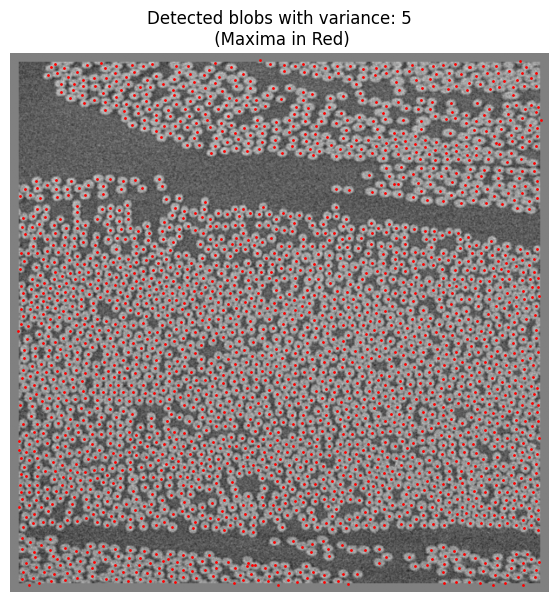

In [24]:
image = get_gray_image(PATH + 'CT_lab_med_res.png')
image_padded = np.pad(image, pad_width=10, mode='constant', constant_values=0.5)

n = 5
t = 5 

kernel = gaussian_1D_kernel(n, t)
image_blurred = convolve_2d(image_padded, kernel)
fiber_locations = peak_local_max(image_blurred, threshold_abs=0.43, threshold_rel=0.45)
plot_image_with_circles(image_padded, local_max=fiber_locations, t=t, circles=False, linewidth=1)
print('The number of blobs is', len(fiber_locations))

**3.  What is the mean radius (in pixels) of the blobs from the image ``CT_lab_med_res.png``**

In [1]:
t_list = np.arange(10, 15, 1)
L_list = []
for t in t_list:
    L = Laplacian(image_blurred, t)
    L_list.append(L)

L_stack = np.stack(L_list, axis=-1)

best_scales = []
for (y, x) in fiber_locations:
    values = L_stack[y, x, :]
    min_index = np.argmin(values)
    best_scale = t_list[min_index]
    best_scales.append((x, y, best_scale))

plt.imshow(image, cmap='gray')
plt.title('Best Scale for Each Fiber')

# Plot cirkler på de fundne positioner og skalaer
for (x, y, scale) in best_scales:
    circle = plt.Circle((x, y), np.sqrt(scale * 3), color='red', fill=False, linewidth=0.5)
    plt.gca().add_patch(circle)

plt.show()


NameError: name 'np' is not defined

In [ ]:
def laplacian(image, t):
    kernel, kernel_dif_2, _ = filter_second_der_filter(t)

    # apply the kernel to the image to blur the image in x direction
    image_filtered_rows = convolve_rows(image, kernel)

    # apply the second derivative in y direction
    L_yy = convolve_columns(image_filtered_rows, kernel_dif_2)

    # apply the kernel to the columns of the image in y direction
    image_filtered_columns = convolve_columns(image, kernel) 

    # second derivative in x direction 
    L_xx = convolve_rows(image_filtered_columns, kernel_dif_2)

    # combine the results
    laplacian_image = L_xx + L_yy

    return laplacian_image, L_xx, L_yy


In [ ]:

""" scales = []
min_responses = []

t_list = np.arange(1, 51)
L_list = []
for t in t_list:
    L = Laplacian(image, t, normalize=True)
    L_list.append(L)

for y, x in local_maxima:
    scale_response = []
    for i, L in enumerate(L_list):
        if y < L.shape[0] and x < L.shape[1]:
            response = L[y, x]
            scale_response.append((t_list[i], response))

    if scale_response:
        min_scale, min_response = min(scale_response, key=lambda x: x[1])
        scales.append(min_scale)
        min_responses.append(min_response)

plt.imshow(image, cmap='gray')
plt.title('Best Scale for Each Fiber')
for (y, x),  scale in zip(local_maxima, scales):
    circle = plt.Circle((x, y), np.sqrt(scale * 3), color='red', fill=False, linewidth=0.5)
    plt.gca().add_patch(circle)

plt.show()
 """